Name: Berkay Doruk

Album Number: 409437  

Lab no: 5

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# Utility class to shift slice indices
class Shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

In [41]:
one = Shift(add=1, sub=1)
hlf = Shift(add=0, sub=1)

def F(psi_l, psi_r, C):
    return 0.5 * (C + np.abs(C)) * psi_l + 0.5 * (C - np.abs(C)) * psi_r

In [42]:
def upwind(psi, i, C):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf])
    )

def solve_upwind(*, nt: int, C: np.ndarray, psi: np.ndarray):
    # Safety check: ensure Courant number |C| < 1 for stability
    assert np.all(np.abs(C) < 1)
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
    return psi

def psi_0(x: np.ndarray, x0: float = 0, a: float = 1, sigma: float = 20):
    return a * np.exp(-((x - x0)**2) / (2 * sigma**2))

In [43]:
def plot(x, **kwargs):
    plt.figure(figsize=(8, 5))
    for label, data in kwargs.items():
        plt.step(x, data, label=label, where='mid')
    plt.legend()
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('psi')
    plt.title('Comparing Analytical and Numerical Solutions')
    plt.show()

In [44]:
u = 2
t_max = 66

nx = 45
nt = 100
dt = t_max / nt
x, dx = np.linspace(-100, 300, nx, retstep=True)

C_array = np.full(nx - 1, u * dt / dx)

In [45]:
def solve_mpdata(*, nt: int, C: np.ndarray, psi: np.ndarray, M: int):
    """  
    Parameters:
      nt : int -Number of time steps.
      C : np.ndarray -Courant number array (constant in time in this example).
      psi : np.ndarray -Initial condition array.
      M : int -Total number of passes:
              M = 1 => standard upwind (no correction)
              M > 1 => additional anti-diffusive passes.
    """
    i_ext = slice(1, len(psi))
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
        for m in range(1, M):
            C_corr = corrective_C(C, i_ext, psi)
            upwind(psi, slice(1, len(C)), C_corr)
    return psi


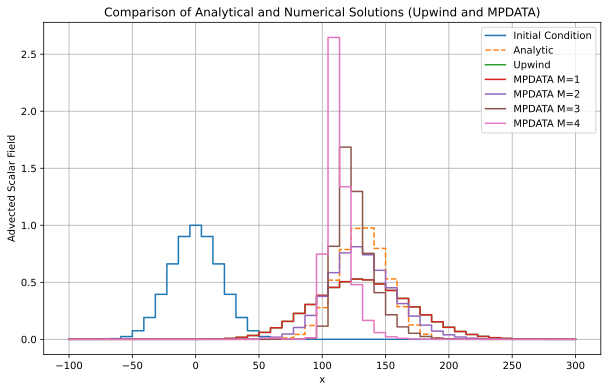

In [49]:
def run_simulation(M: int):
    psi_initial = psi_0(x)
    psi = psi_initial.copy()
    psi_final = solve_mpdata(nt=nt, C=C_array, psi=psi, M=M)
    return psi_final

iterations = [1, 2, 3, 4]
results = {f"MPDATA M={M}": run_simulation(M) for M in iterations}

psi_upwind = solve_upwind(nt=nt, C=C_array, psi=psi_0(x).copy())
analytic = psi_0(x - u*t_max)

"""
MPDATA M=1 and Upwind are the same; that's why it's not visible separately.
"""
plt.figure(figsize=(10, 6))
plt.step(x, psi_0(x), label="Initial Condition", where='mid')
plt.step(x, analytic, label="Analytic", where='mid', linestyle='--')
plt.step(x, psi_upwind, label="Upwind", where='mid')
for label, result in results.items():
    plt.step(x, result, label=label, where='mid')
plt.xlabel('x')
plt.ylabel('Advected Scalar Field')
plt.title('Comparison of Analytical and Numerical Solutions (Upwind and MPDATA)')
plt.legend()
plt.grid(True)

plt.savefig("plot.svg")
plt.savefig("plot.pdf")

plt.show()